In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten , Input, BatchNormalization, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model as M

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')

# Moments_complexes


In [4]:
def moment_complexe(image,p,q):
    n,m = image.shape
    s=0
    for x in range(n):
        for y in range(m):
            s += (x + 1j * y)**p * (x - 1j * y)**q * image[x,y]
    return s

In [5]:
from numpy import exp
p_0 = 2
def invariant_rotation(image,p,q):
    return (moment_complexe(image,p_0 -1 ,p_0) ** (p-q)) * moment_complexe(image,p,q)

In [6]:
import cmath
def invariant_complet(image,p,q):
        theta = cmath.phase(invariant_rotation(image,1,0))
        gamma = (invariant_rotation(image,0,0)) ** (1/2)
        return (gamma ** -(p+q+2) )*(exp(-(p-q)*theta*1j))*moment_complexe(image,p,q)

# Libraries Importation 

In [7]:
import numpy as np
import cmath

In [8]:
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
#(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

C:\Users\ghass\anaconda\envs\test3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
##from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
##(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess the data
#x_train = x_train.astype('float32') / 255.0
#x_test = x_test.astype('float32') / 255.0
##y_train = to_categorical(y_train, num_classes=10)
##y_test = to_categorical(y_test, num_classes=10)

from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Define the selected classes
selected_classes = [0, 1, 2, 3, 4]

# Create masks to filter the data for the selected classes
train_mask = np.isin(y_train, selected_classes).flatten()
test_mask = np.isin(y_test, selected_classes).flatten()

# Filter the data based on the masks
x_train_subset = x_train[train_mask]
y_train_subset = y_train[train_mask]
x_test_subset = x_test[test_mask]
y_test_subset = y_test[test_mask]

# Preprocess the data
x_train_subset = x_train_subset.astype('float32') / 255.0
x_test_subset = x_test_subset.astype('float32') / 255.0

# You should one-hot encode the labels for the selected classes
y_train_subset = to_categorical(y_train_subset, num_classes=len(selected_classes))
y_test_subset = to_categorical(y_test_subset, num_classes=len(selected_classes))


# VGG16 (CNN model)

In [10]:
from tensorflow.keras.applications import VGG16,DenseNet121,EfficientNetB0 
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [13]:
# Add a max pooling layer, a flatten layer, and a dense classification layer
x = base_model.output 
x = Flatten()(x)  # Flatten the output to connect to a dense layer
x = Dense(1024,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1024,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256,activation='relu')(x)
x = Dense(5, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
#model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))
history = model.fit(x_train_subset, y_train_subset, batch_size=64, epochs=30, validation_data=(x_test_subset, y_test_subset))
print("Best accuracy:", np.max(history.history["val_accuracy"])) 

Epoch 1/30
391/391 [==============================] - 45s 115ms/step - loss: 0.9157 - accuracy: 0.6737 - val_loss: 0.7521 - val_accuracy: 0.7198
Epoch 2/30
391/391 [==============================] - 45s 115ms/step - loss: 0.6462 - accuracy: 0.7590 - val_loss: 0.7074 - val_accuracy: 0.7404
Epoch 3/30
391/391 [==============================] - 43s 110ms/step - loss: 0.5675 - accuracy: 0.7868 - val_loss: 0.7126 - val_accuracy: 0.7558
Epoch 4/30
391/391 [==============================] - 46s 117ms/step - loss: 0.5101 - accuracy: 0.8081 - val_loss: 0.7520 - val_accuracy: 0.7364
Epoch 5/30
391/391 [==============================] - 44s 112ms/step - loss: 0.4678 - accuracy: 0.8239 - val_loss: 0.7569 - val_accuracy: 0.7414
Epoch 6/30
391/391 [==============================] - 53s 135ms/step - loss: 0.4255 - accuracy: 0.8378 - val_loss: 0.8064 - val_accuracy: 0.7288
Epoch 7/30
391/391 [==============================] - 46s 119ms/step - loss: 0.3754 - accuracy: 0.8586 - val_loss: 0.8013 - val_ac

accuracy: 72 %  (low needs more training images)

validation accuracy: 59% 

There is a slight overfitting

In [20]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

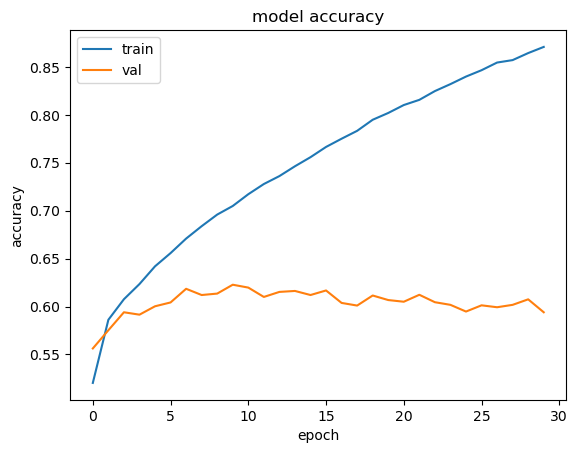

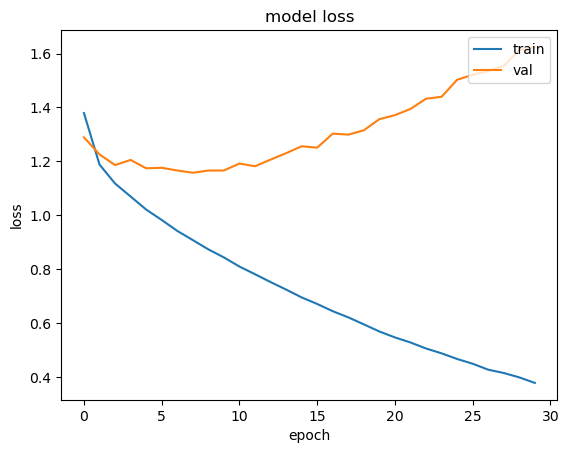

In [21]:
# Accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [14]:
model.save('model.h5')

In [15]:
print(x_train.shape,y_train.shape)
print(np.argmax(y_train))

(50000, 32, 32, 3) (50000, 10)
6


# Handcrafted Model (VGG16 + moments invariants)

In [16]:
import cv2
import numpy as np
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
import sklearn
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Extract CNN features using a small CNN-based classifier
# Function to convert the image to grayscale
def convert_to_grayscale(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return grayscale_image

# Function to convert images to binary or grayscale
def convert_to_binary_or_grayscale(images, use_binary=True, threshold_value=128):
    processed_images = []
    for img in images:
        # Convert to grayscale (if needed)
        gray_img = convert_to_grayscale(img)
        # Convert to binary image (if needed)
        binary_img = convert_to_binary(gray_img, threshold_value) if use_binary else gray_img
        processed_images.append(binary_img)
    return np.array(processed_images)
def extract_cnn_features(images):
    # Extract features using the small CNN-based model
    cnn_features = base_model.predict(images)
    return cnn_features

# Compute moment invariants for each image
def compute_moment_invariants(images):
    moment_invariants_list = []
    for img in images:
        # Assuming you have a function to convert the image to grayscale
        grayscale_image = convert_to_grayscale(img)
        # Compute moment invariants using OpenCV or any other library
        moments = cv2.moments(grayscale_image)
        moment_invariants = cv2.HuMoments(moments).flatten()
        moment_invariants_list.append(moment_invariants)
    return np.array(moment_invariants_list)

# Function to convert the image to grayscale
def convert_to_grayscale(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return grayscale_image

# Preprocess the CIFAR-10 dataset and obtain 'images' and 'labels'
images = x_train
labels = np.argmax(y_train, axis=1)  # Convert one-hot encoded labels to integer labels

# Extract CNN features and moment invariants
cnn_features = extract_cnn_features(images)
moment_invariants = compute_moment_invariants(images)

num_moment_invariants = moment_invariants.shape[0]

# Reshape cnn_features to (num_moment_invariants, -1), where -1 will infer the remaining dimensions
cnn_features_flattened = cnn_features.reshape(num_moment_invariants, -1)

# Combine features
combined_features = np.concatenate([cnn_features_flattened, moment_invariants], axis=1)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

# Create a new model for classification
classifier = Sequential()
classifier.add(Dense(256, activation='relu'))
classifier.add(Dense(10, activation='softmax'))

# Compile the model
optimizer = Adam(lr=0.001)
classifier.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
history = classifier.fit(x_train, y_train, batch_size=32, epochs=30, validation_split=0.1)

# Evaluate the classifier
accuracy = classifier.evaluate(x_test, y_test, verbose=1)[1]
print("Test Accuracy:", accuracy)

Epoch 1/30
1125/1125 [==============================] - 1s 856us/step - loss: 1.3794 - accuracy: 0.5203 - val_loss: 1.2893 - val_accuracy: 0.5562
Epoch 2/30
1125/1125 [==============================] - 1s 718us/step - loss: 1.1887 - accuracy: 0.5862 - val_loss: 1.2261 - val_accuracy: 0.5753
Epoch 3/30
1125/1125 [==============================] - 1s 729us/step - loss: 1.1183 - accuracy: 0.6076 - val_loss: 1.1866 - val_accuracy: 0.5940
Epoch 4/30
1125/1125 [==============================] - 1s 753us/step - loss: 1.0702 - accuracy: 0.6234 - val_loss: 1.2057 - val_accuracy: 0.5915
Epoch 5/30
1125/1125 [==============================] - 1s 790us/step - loss: 1.0219 - accuracy: 0.6419 - val_loss: 1.1747 - val_accuracy: 0.6003
Epoch 6/30
1125/1125 [==============================] - 1s 801us/step - loss: 0.9833 - accuracy: 0.6557 - val_loss: 1.1765 - val_accuracy: 0.6043
Epoch 7/30
1125/1125 [==============================] - 1s 743us/step - loss: 0.9427 - accuracy: 0.6709 - val_loss: 1.1666 -

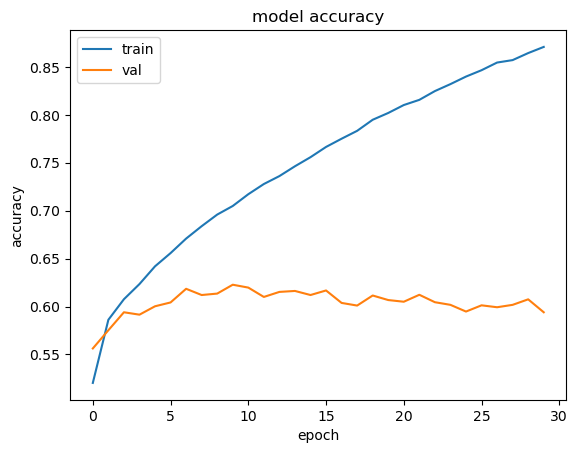

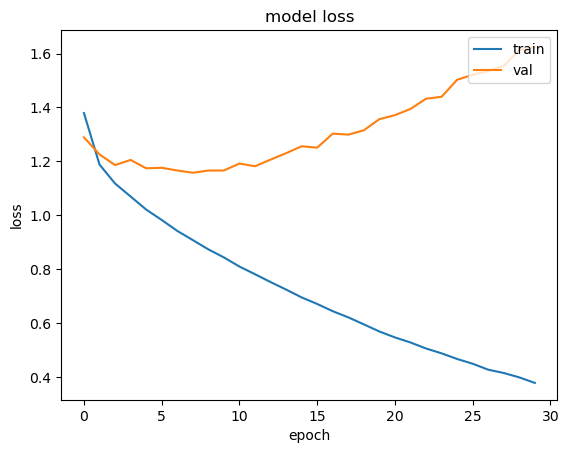

In [17]:
# Accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

accuracy : 86% (better than the VGG16 alone )

validation accuracy : 60.35 (slight improvement )

The moments invariants adds the character of invariance (rotation,translation,scale) to the CNN model (pretrained model in our case VGG16 lacking this feature) .

In [18]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               133120    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 135,690
Trainable params: 135,690
Non-trainable params: 0
_________________________________________________________________


In [19]:
classifier.save('hu_classifier.h5')
from tensorflow.keras.models import load_model 
New_Model=load_model('hu_classifier.h5')

In [15]:
base_model_2 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [17]:
# Add a max pooling layer, a flatten layer, and a dense classification layer
x = base_model_2.output 
x = Flatten()(x)  # Flatten the output to connect to a dense layer
x = Dense(1024,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1024,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256,activation='relu')(x)
x = Dense(5, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model_2.input, outputs=x)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
#model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))
history = model.fit(x_train_subset, y_train_subset, batch_size=64, epochs=30, validation_data=(x_test_subset, y_test_subset))
print("Best accuracy:", np.max(history.history["val_accuracy"])) 

Epoch 1/30
391/391 [==============================] - 421s 1s/step - loss: 1.3399 - accuracy: 0.4052 - val_loss: 3.6373 - val_accuracy: 0.2016
Epoch 2/30
391/391 [==============================] - 386s 987ms/step - loss: 1.0366 - accuracy: 0.5367 - val_loss: 2.0422 - val_accuracy: 0.3760
Epoch 3/30
391/391 [==============================] - 378s 966ms/step - loss: 0.7818 - accuracy: 0.6831 - val_loss: 0.9105 - val_accuracy: 0.6420
Epoch 4/30
391/391 [==============================] - 378s 966ms/step - loss: 0.6654 - accuracy: 0.7375 - val_loss: 0.7285 - val_accuracy: 0.7024
Epoch 5/30
391/391 [==============================] - 381s 974ms/step - loss: 0.5824 - accuracy: 0.7776 - val_loss: 0.6985 - val_accuracy: 0.7080
Epoch 6/30
391/391 [==============================] - 380s 973ms/step - loss: 0.5008 - accuracy: 0.8146 - val_loss: 0.9264 - val_accuracy: 0.6520
Epoch 7/30
391/391 [==============================] - 379s 968ms/step - loss: 0.4303 - accuracy: 0.8457 - val_loss: 0.7968 - va